# SVM Practice Session
In this session, we will see how to use Support Vector Machines (SVM) to classify data. In a first time, we will work with generated data, and then we will use SVM to try and predict pulsars stars.

## Imports

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Data generation

In [3]:
# We generate 1000 points, with 2 features, and 2 classes
# Let's pick a center for each class
center1 = np.array([0, 0])
center2 = np.array([1, 1])
# We generate 500 points around each center, distributed normally
data1 = np.random.normal(loc=center1, # mean
                         scale=(0.5, 0.3), # std deviation
                         size=(500, 2))
data2 = np.random.normal(loc=center2, # mean
                         scale=(0.3, 0.5), # std deviation
                         size=(500, 2))
# We create the labels
labels1 = np.zeros(500)
labels2 = np.ones(500)
# We concatenate the data and the labels
data1 = np.concatenate((data1, labels1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data2, labels2.reshape(-1, 1)), axis=1)
# We concatenate the two classes
data = np.concatenate((data1, data2), axis=0)
# We shuffle the data
np.random.shuffle(data)
# We split the data into train, and test sets (80% / 20 %)
train, test = train_test_split(data, test_size=0.2, stratify=data[:, 2])
# (optional)
# We make a dataframe to plot the data, with columns x, y, label, set
df = pandas.DataFrame(data, columns=['Feature1', 'Feature2', 'Label'])
# We save the data
# df.to_csv('data.csv', index=False)


Let's plot the data, to see what it looks like

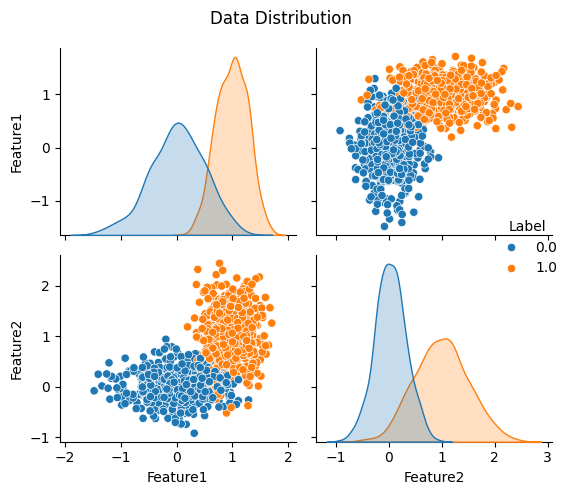

In [4]:
sns.pairplot(df, hue='Label')
plt.suptitle('Data Distribution')
plt.tight_layout()
plt.show()

## SVM 

Note : use the GridSearchCV() function from sklearn to find the best hyperparameters for the SVM model.
In order to plot the results of the grid search, you may consider heatmaps.
Howerever, you may notice that we are concidering 3 hyperparameters, which makes it impossible to plot in a 2D space, and a 3D heatmap may be hard to read.
Hence, you may consider plotting only 2 hyperparameters at a time, and average over the third one !

To get the results from GridSearchCV, you may use `grid.cv_results_["mean_test_score"]` and `grid.cv_results_["params"]` to get the mean test score and the hyperparameters used for each fold.
A 'nice' way of getting a unified collection of the hyperparameters and their corresponding score would be a peice of code such as :
```python
d = []
i=0
for p in grid.cv_results_["params"]:
    d.append(p)
    d[-1]["result"] = grid.cv_results_["mean_test_score"][i]
    i += 1
print(d)
``` 

In [5]:
# We tune the hyperparameters : C, kernel, gamma
param_grid = [
	{'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
	{'kernel': ['poly'], 'C': [0.1, 1, 10, 100, 1000]},
	{'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10]},
 ]

# We make a classifier
clf = svm.SVC()

# We make a grid search using GridSearchCV()
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Note: the cross-validation behind GridSearchCV automatically splits the data into
# training and validation sets for each fold. It trains the model on the training set and
# evaluates its performance on the validation set. This process is repeated for each fold,
# and the average performance is used to assess the model's generalization ability.
# GridSearchCV exhaustively tests all possible combinations of hyperparameters specified
# in the hyperparams dictionary, and selects the combination that gives the best average
# performance across all folds. This helps in finding the optimal hyperparameters for the
# Support Vector Machine model without manually trying each combination.

# We train it
grid_search.fit(train[:, :2], train[:, 2])

# We print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# We select the best model and print the accuracy on the test set
print('Accuracy on the train set:', grid_search.best_estimator_.score(train[:, :2], train[:, 2]))
print('Accuracy on the test set:', grid_search.best_estimator_.score(test[:, :2], test[:, 2]))

Best hyperparameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on the train set: 0.955
Accuracy on the test set: 0.965


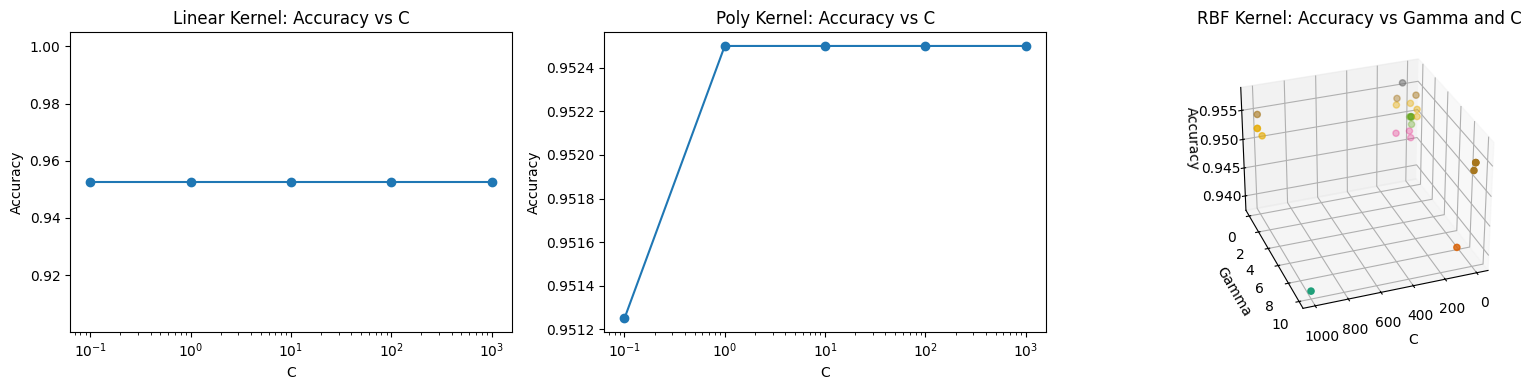

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Group Results
results = grid_search.cv_results_

results_df = pandas.DataFrame(results['params'])
results_df['mean_test_score'] = results['mean_test_score']

linear_results_df = results_df[results_df['kernel'] == 'linear']
poly_results_df = results_df[results_df['kernel'] == 'poly']
rbf_results_df = results_df[results_df['kernel'] == 'rbf']

linear_grouped = linear_results_df.groupby('C')['mean_test_score'].mean().reset_index()
linear_C = linear_grouped['C']
linear_results = linear_grouped['mean_test_score']

poly_grouped = poly_results_df.groupby('C')['mean_test_score'].mean().reset_index()
poly_C = poly_grouped['C']
poly_results = poly_grouped['mean_test_score']

rbf_grouped = rbf_results_df.groupby(['C', 'gamma'])['mean_test_score'].mean().reset_index()
rbf_C = rbf_grouped['C']
rbf_gamma = rbf_grouped['gamma']
rbf_results = rbf_grouped['mean_test_score']

# Plot
fig = plt.figure(figsize=(16, 4))

ax1 = fig.add_subplot(131)
ax1.plot(linear_C, linear_results, marker='o')
ax1.set_xscale('log')
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')
ax1.set_title('Linear Kernel: Accuracy vs C')

ax2 = fig.add_subplot(132)
ax2.plot(poly_C, poly_results, marker='o')
ax2.set_xscale('log')
ax2.set_xlabel('C')
ax2.set_ylabel('Accuracy')
ax2.set_title('Poly Kernel: Accuracy vs C')

# Plot the rbf kernel results
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(rbf_C, rbf_gamma, rbf_results, c=rbf_results, cmap='Dark2')
ax3.view_init(elev=30, azim=70)
ax3.set_xlabel('C')
ax3.set_ylabel('Gamma')
ax3.set_zlabel('Accuracy')
ax3.set_title('RBF Kernel: Accuracy vs Gamma and C')

plt.tight_layout()
plt.show();

Text(0.5, 0.92, 'RBF Kernel: Accuracy vs Gamma and C')

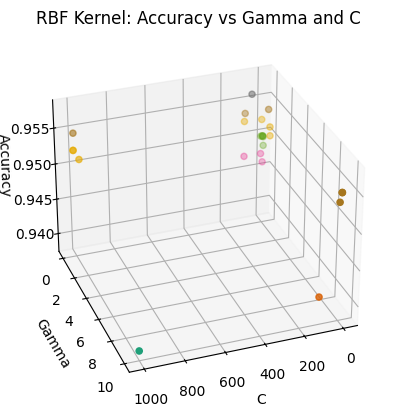

In [7]:
ax2 = plt.subplot(projection='3d')
ax2.scatter(rbf_C, rbf_gamma, rbf_results, c=rbf_results, cmap='Dark2')
# ax2.set_xscale('log')
# ax2.set_xscale('log')
ax2.view_init(elev=30, azim=70)
ax2.set_xlabel('C')
ax2.set_ylabel('Gamma')
ax2.set_zlabel('Accuracy')
ax2.set_title('RBF Kernel: Accuracy vs Gamma and C')

## We can also plot the decision boundary

For better insight, we plot the decision boundary of the classifier with the hyperparameters : (C=1, kernel="linear"), (C=1, kernel="rbf"), (C=100, kernel="linear"), (C=100, kernel="rbf")

In [8]:
models = {1: {'C': 1, 'kernel': 'linear'},
          2: {'C': 1, 'kernel': 'rbf'},
          3: {'C': 100, 'kernel': 'linear'},
          4: {'C': 100, 'kernel': 'rbf'}}

# We make the classifiers
clfs = {key: svm.SVC(C=value['C'], kernel=value['kernel']) for key, value in models.items()}

# We train them
for key, clf in clfs.items():
    clf.fit(train[:, :2], train[:, 2])
    print(f'Accuracy for model {key}: {clf.score(train[:, :2], train[:, 2])}')

# We get the accuracy on the test set
accuracies = {key: clf.score(test[:, :2], test[:, 2]) for key, clf in clfs.items()}

Accuracy for model 1: 0.95125
Accuracy for model 2: 0.95375
Accuracy for model 3: 0.95125
Accuracy for model 4: 0.955


Note : In order to predict the full space xx, yy, you will need to use something as 
```python
model.predict(np.c_[xx.ravel(), yy.ravel()])
```
Please, note the use of `np.c_` to concatenate the two arrays, and the use of `ravel()` to flatten the arrays.

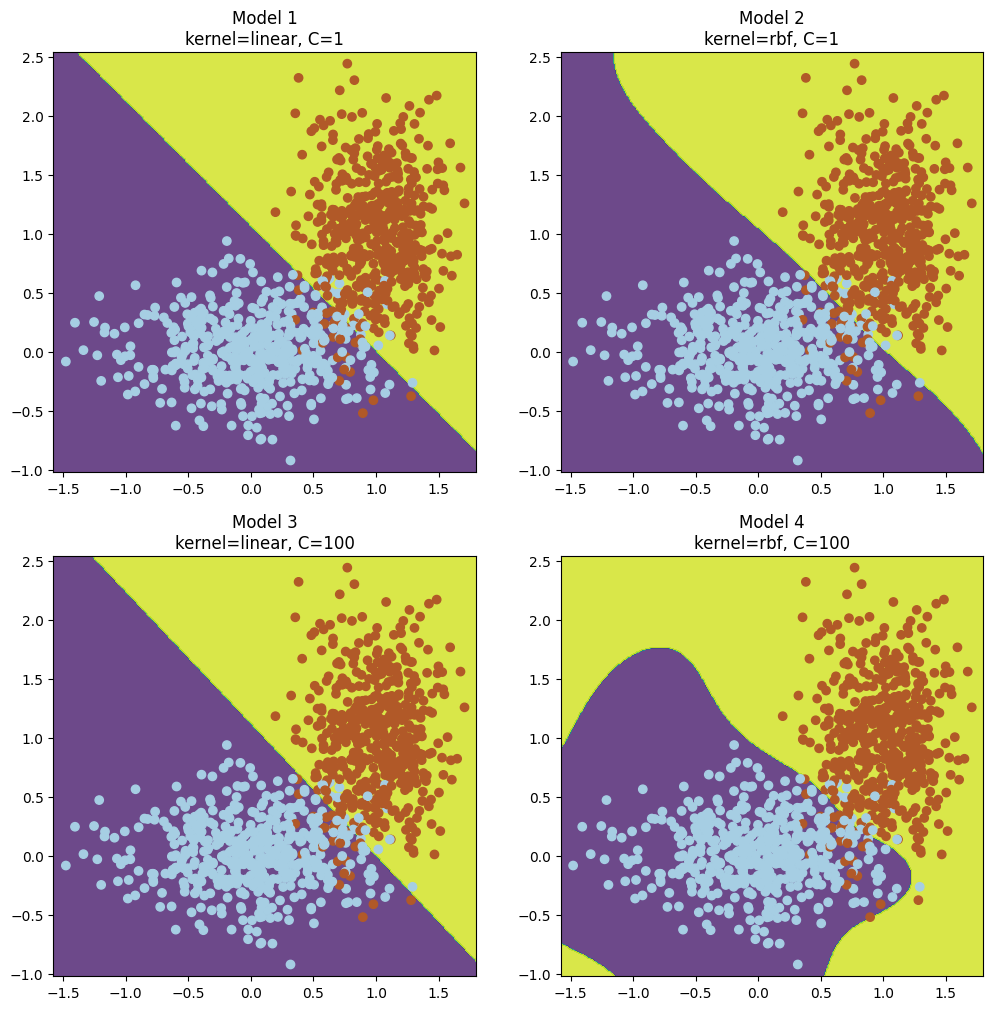

In [9]:
# We create a grid of points
x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# We plot the decision boundary for each classifier and print the accuracy on the test set

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, (key, value) in zip(axes.ravel(), models.items()):
    # We predict the labels for each point in the grid
    Z = clfs[key].predict(np.c_[xx.ravel(), yy.ravel()])
    # We reshape the predictions to match the grid
    Z = Z.reshape(xx.shape)
    # We plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.8)
    # We plot the data
    ax.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=plt.cm.Paired)
    ax.set_title(f"Model {key}\nkernel={models[key]['kernel']}, C={models[key]['C']}");

# Note: the model has been trained on the whole training set for each plot, that's why we do not get the exact same test accuracy as with the grid search (which used cross-validation).

## Real data - Pulsar stars

Apply the same procedure as in the previous section to find the best parameters for the pulsar dataset using cross-fold validation. The data is to be found with along to this notebook. The files are :
- pulsar_data_train.csv on which you must perform the training and validation
- pulsar_data_test.csv on which you must test your model.
The interest of having a separate 'test' file is that everybody can eveluate their model equialy. 
Competitions websites such as Kaggle keep there test dataset private to evaluate all participants' models on the same secrete data !

### Description

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In particular, classification systems are widely adopted, which treat the candidate datasets as binary classification problems.

### Heandling missing values

Somes values of the features are missing. You can use the `SimpleImputer` from `sklearn.impute` to fill the missing values. Or any other method you prefer.

You can load the data into a dataframe using the below code snippet:

```python
import pandas as pd
input_file = "pulsar_data_train.csv"
df = pd.read_csv(input_file)
```

### More information

Refer to the project's instructions for more information on this part.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
train_data = pd.read_csv("pulsar_data_train.csv")
print("Table size: ", train_data.shape)
train_data.head()

Table size:  (12528, 9)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [12]:
train_data.target_class.value_counts()

target_class
0.0    11375
1.0     1153
Name: count, dtype: int64

In [13]:
train_data.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

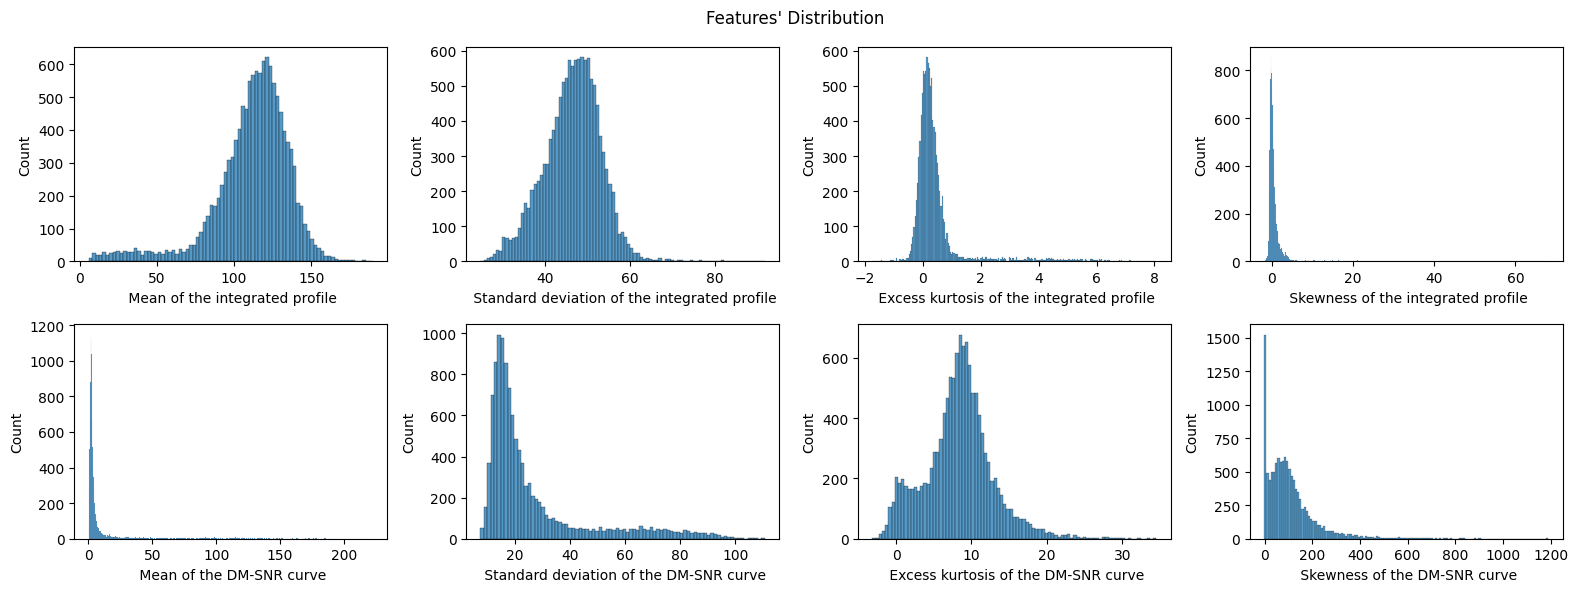

In [14]:
fix, axes = plt.subplots(2, 4, figsize=(16, 6))

for column in train_data.columns[:-1]:
	sns.histplot(train_data[column], ax=axes.flatten()[train_data.columns.get_loc(column)])

plt.suptitle("Features' Distribution")
plt.tight_layout();

After imputing with Mean and with Mode:


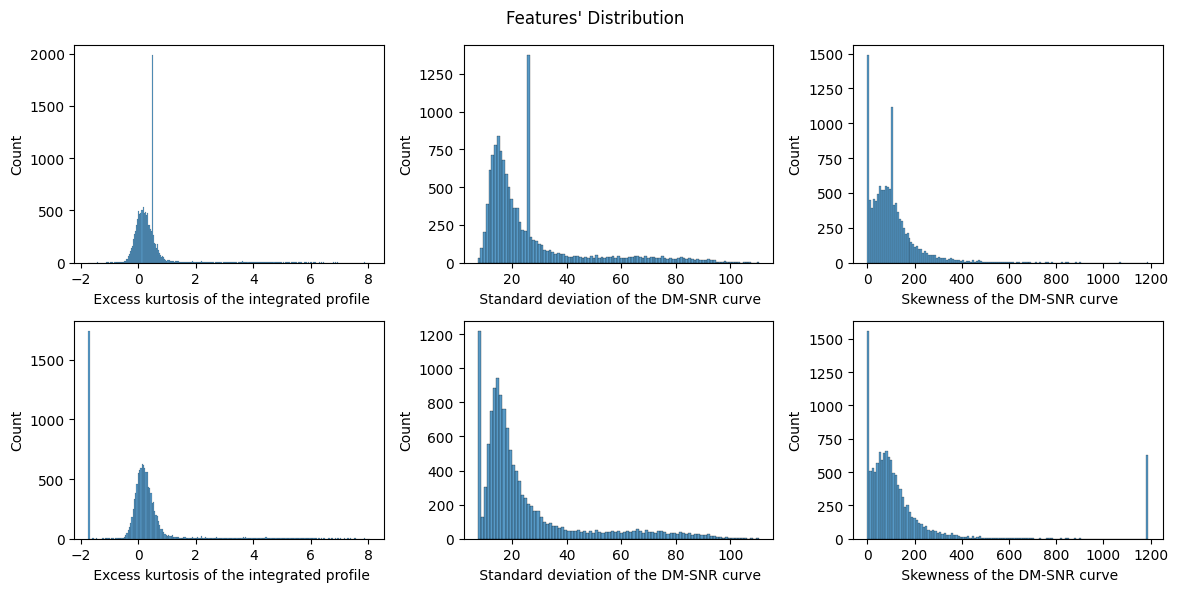

In [15]:
train_data_mean = train_data.fillna(train_data.mean())
train_data_mode = train_data.apply(lambda x: x.fillna(x.mode()[0]))

print("After imputing with Mean and with Mode:")
fix, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for column in [
	' Excess kurtosis of the integrated profile',
	' Standard deviation of the DM-SNR curve',
	' Skewness of the DM-SNR curve'
]:
	sns.histplot(train_data_mean[column], ax=axes.flatten()[i])
	sns.histplot(train_data_mode[column], ax=axes.flatten()[i+3])
	i+=1

plt.suptitle("Features' Distribution")
plt.tight_layout();

In [16]:
pd.isna(train_data_mean).sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

X = train_data.drop('target_class', axis=1)
y = train_data['target_class']

X = X.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=5, weights="distance")
X = imputer.fit_transform(X)

After imputing with KNN:


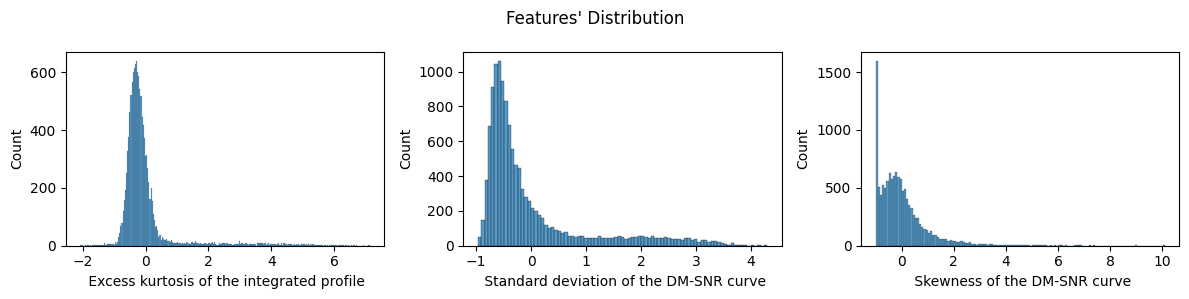

In [18]:
X_og = pd.DataFrame(X, columns=train_data.drop('target_class', axis=1).columns)
X_og['target_class'] = y

print("After imputing with KNN:")
fix, axes = plt.subplots(1, 3, figsize=(12, 3))

i = 0
for column in [
	' Excess kurtosis of the integrated profile',
	' Standard deviation of the DM-SNR curve',
	' Skewness of the DM-SNR curve'
]:
	sns.histplot(X_og[column], ax=axes.flatten()[i])
	i+=1

plt.suptitle("Features' Distribution")
plt.tight_layout();

In [19]:
X_og.isna().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

small_train_data = X_og.sample(frac=1, random_state=7)

X_train_small = small_train_data.drop('target_class', axis=1)
y_train_small = small_train_data['target_class']

# Split the data (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_small, y_train_small, 
                                                   test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=y_train_small)

# Display the shape of the resulting datasets
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Class distribution in training: {y_train.value_counts().to_dict()}")
print(f"Class distribution in validation: {y_val.value_counts().to_dict()}")

Training set: 10022 samples
Validation set: 2506 samples
Class distribution in training: {0.0: 9100, 1.0: 922}
Class distribution in validation: {0.0: 2275, 1.0: 231}


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = [
	#{'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
	{'kernel': ['poly'], 'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4]},
	{'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10]},
 ]

clf = SVC(
	class_weight='balanced',
    probability=True)
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Accuracy on the train set:', grid_search.best_estimator_.score(X_train, y_train))
print('Accuracy on the test set:', grid_search.best_estimator_.score(X_val, y_val))

Best hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy on the train set: 0.9750548792656156
Accuracy on the test set: 0.9728651237031125


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# param_grid = {
#     'C': Real(0.1, 1000, prior='log-uniform'),
#     'gamma': Real(0.0001, 10, prior='log-uniform'),
#     'kernel': Categorical(['linear', 'poly', 'rbf']),
#     'degree': Integer(2, 5)
# }

param_grid = {
    'C': Categorical([0.1, 1, 10]),
    'gamma': Categorical([0.001, 0.01, 0.1, 1]),
    'kernel': Categorical(['poly', 'rbf']),
    'degree': Categorical([2, 3, 4])
}

svm_model = SVC(class_weight='balanced',
                probability=True)
bayes_search = BayesSearchCV(
    svm_model,
    param_grid,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)

print("Best hyperparameters (Bayesian Optimization):", bayes_search.best_params_) # as degree is included as a categorical variable, it will be displayed in the best hyperparameters even for rbf (but SVM ignores it)
print("Accuracy on training set:", bayes_search.best_estimator_.score(X_train, y_train))
print("Accuracy on validation set:", bayes_search.best_estimator_.score(X_val, y_val))


Best hyperparameters (Bayesian Optimization): OrderedDict({'C': 1, 'degree': 4, 'gamma': 0.01, 'kernel': 'rbf'})
Accuracy on training set: 0.9750548792656156
Accuracy on validation set: 0.9728651237031125


BayesSearchCV approach was also tried for hyperparameter tuning. 
With the same hyperparameter combinations GridSearchCV perform faster (best_params are the same) as it is directly evaluates all combinations in parallel. Bayesian optimization usually provides better results when the search space is large and continuous.
So we tried continuous search spaces for C and gamma to provide more flexibility in parameter selection, but  it does not make a significant improvement. Instead, it increases the model building time.
It seems that 0.972 is already close to the theoretical best possible accuracy for this dataset, and BayesSearchCV can’t push it much further even though it theoretically should perform better. Increasing the number of iterations to 30–50 could give us slightly higher results, but it requires much more computational power and even that not guarantee noticeably better result.

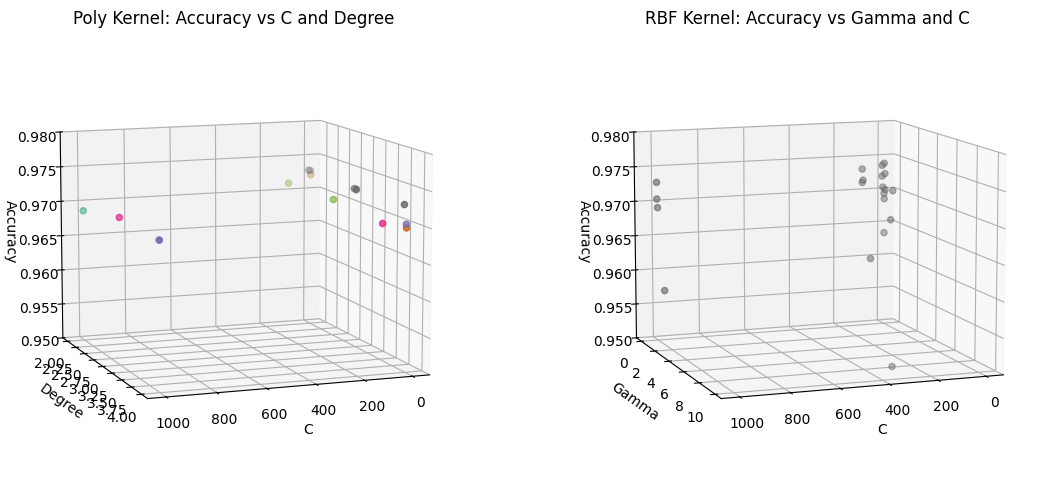

In [40]:
# Group Results
results = grid_search.cv_results_

results_df = pandas.DataFrame(results['params'])
results_df['mean_test_score'] = results['mean_test_score']

poly_results_df = results_df[results_df['kernel'] == 'poly']
rbf_results_df = results_df[results_df['kernel'] == 'rbf']

poly_grouped = poly_results_df.groupby(['C', 'degree'])['mean_test_score'].mean().reset_index()
poly_C = poly_grouped['C']
poly_degree = poly_grouped['degree']
poly_results = poly_grouped['mean_test_score']

rbf_grouped = rbf_results_df.groupby(['C', 'gamma'])['mean_test_score'].mean().reset_index()
rbf_C = rbf_grouped['C']
rbf_gamma = rbf_grouped['gamma']
rbf_results = rbf_grouped['mean_test_score']

# Plot
fig = plt.figure(figsize=(12, 5))

ax2 = fig.add_subplot(121, projection='3d')
ax2.scatter(poly_C, poly_degree, poly_results, c=poly_results, cmap='Dark2')
ax2.view_init(elev=10, azim=70)
ax2.set_xlabel('C')
ax2.set_ylabel('Degree')
ax2.set_zlabel('Accuracy')
ax2.set_zlim(0.95, 0.98)
ax2.set_title('Poly Kernel: Accuracy vs C and Degree')

# Plot the rbf kernel results
ax3 = fig.add_subplot(122, projection='3d')
ax3.scatter(rbf_C, rbf_gamma, rbf_results, c=rbf_results, cmap='Dark2')
ax3.view_init(elev=10, azim=70)
ax3.set_xlabel('C')
ax3.set_ylabel('Gamma')
ax3.set_zlabel('Accuracy')
ax3.set_zlim(0.95, 0.98)
ax3.set_title('RBF Kernel: Accuracy vs Gamma and C')

plt.tight_layout()
plt.show();